In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from tqdm import tqdm
from sklearn.utils import shuffle
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [4]:
data_folder = "/content/drive/MyDrive/AML_ex"
data_files = os.listdir(data_folder)

# # Settings
# verbose = True
# batch_size = 256
# dropout = 0.5
# hidden_dims = 128
# epochs = 10
# filters = 128
# filters2 = 64
# kernel_size = 50
# kernel_size2 = 50

In [5]:
data_files

['yso_preprocessed',
 'acep_preprocessed',
 't2cep_preprocessed',
 'acv_preprocessed',
 'ecl_preprocessed']

In [6]:
labels = [file.split('_')[0] for file in data_files]

In [7]:
labels

['yso', 'acep', 't2cep', 'acv', 'ecl']

In [8]:
data = []
labels = []

for folder in data_files:
    if folder.endswith('_preprocessed'):
        label = folder.split('_')[0]
        folder_path = os.path.join(data_folder, folder)
        files = os.listdir(folder_path)
        for file in files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            data.append(df[['time_diff', 'mag_diff']].values)
            labels.append(label)

data = np.array(data)
labels = np.array(labels)

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [10]:
labels

array(['yso', 'yso', 'yso', ..., 'ecl', 'ecl', 'ecl'], dtype='<U5')

In [11]:
encoded_labels

array([4, 4, 4, ..., 2, 2, 2])

In [12]:
data

array([[[ 0.000000e+00,  0.000000e+00],
        [ 1.137000e-02,  2.000000e-03],
        [ 1.250000e-02, -1.600000e-02],
        ...,
        [ 1.129000e-02, -1.900000e-02],
        [ 1.132000e-02, -2.100000e-02],
        [ 1.129000e-02, -3.700000e-02]],

       [[ 0.000000e+00,  0.000000e+00],
        [ 1.724000e-02,  1.000000e-03],
        [ 1.067000e-02,  0.000000e+00],
        ...,
        [ 1.112000e-02,  7.000000e-03],
        [ 1.071000e-02,  1.000000e-03],
        [ 1.072000e-02,  7.000000e-03]],

       [[ 0.000000e+00,  0.000000e+00],
        [ 1.068000e-02, -1.200000e-02],
        [ 1.066000e-02,  3.000000e-03],
        ...,
        [ 1.072000e-02,  7.000000e-03],
        [ 1.075000e-02,  1.000000e-03],
        [ 1.069000e-02,  4.000000e-03]],

       ...,

       [[ 0.000000e+00,  0.000000e+00],
        [ 8.040320e+00,  9.900000e-02],
        [ 1.959390e+00, -1.960000e-01],
        ...,
        [ 3.991390e+00,  1.190000e-01],
        [ 4.981640e+00, -1.730000e-01],
        [

In [13]:
from collections import Counter

label_counts = Counter(labels)
filtered_labels = [label for label in label_counts if label_counts[label] >= 200]

filtered_data = []
filtered_encoded_labels = []
for i, label in enumerate(labels):
    if label in filtered_labels:
        filtered_data.append(data[i])
        filtered_encoded_labels.append(encoded_labels[i])

filtered_data = np.array(filtered_data)
filtered_encoded_labels = np.array(filtered_encoded_labels)


In [14]:
filtered_encoded_labels

array([0, 0, 0, ..., 2, 2, 2])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(filtered_data, filtered_encoded_labels, test_size=0.2, random_state=42)

In [16]:
X_train

array([[[ 0.000000e+00,  0.000000e+00],
        [ 9.186200e-01, -9.600000e-02],
        [ 6.048770e+00,  7.600000e-02],
        ...,
        [ 0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00]],

       [[ 0.000000e+00,  0.000000e+00],
        [ 9.054500e-01, -1.160000e-01],
        [ 1.135000e-02,  0.000000e+00],
        ...,
        [ 1.135000e-02, -6.000000e-03],
        [ 1.134000e-02,  1.100000e-02],
        [ 1.139000e-02,  1.600000e-02]],

       [[ 0.000000e+00,  0.000000e+00],
        [ 6.050030e+00, -3.360000e-01],
        [ 1.099327e+01,  3.700000e-02],
        ...,
        [ 0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00],
        [ 0.000000e+00,  0.000000e+00]],

       ...,

       [[ 0.000000e+00,  0.000000e+00],
        [ 2.581000e-02,  8.800000e-02],
        [ 6.022940e+00, -1.390000e-01],
        ...,
        [ 1.981560e+00, -1.400000e-02],
        [ 2.649000e-02, -4.200000e-02],
        [

In [17]:
y_train

array([2, 2, 2, ..., 2, 2, 3])

In [18]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(None, 2)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tensorboard = TensorBoard(log_dir='./logs')

model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2, callbacks=[early_stopping, tensorboard])


Epoch 1/10
13/13 [==============================] - 60s 4s/step - loss: 1.2704 - accuracy: 0.7286 - val_loss: 0.6924 - val_accuracy: 0.7921
Epoch 2/10
13/13 [==============================] - 28s 2s/step - loss: 0.7149 - accuracy: 0.7828 - val_loss: 0.6512 - val_accuracy: 0.7921
Epoch 3/10
13/13 [==============================] - 29s 2s/step - loss: 0.6930 - accuracy: 0.7832 - val_loss: 0.6550 - val_accuracy: 0.7921
Epoch 4/10
13/13 [==============================] - 31s 2s/step - loss: 0.6766 - accuracy: 0.7832 - val_loss: 0.6463 - val_accuracy: 0.7921
Epoch 5/10
13/13 [==============================] - 30s 2s/step - loss: 0.6794 - accuracy: 0.7828 - val_loss: 0.6577 - val_accuracy: 0.7921
Epoch 6/10
13/13 [==============================] - 30s 2s/step - loss: 0.6771 - accuracy: 0.7832 - val_loss: 0.6457 - val_accuracy: 0.7921
Epoch 7/10
13/13 [==============================] - 29s 2s/step - loss: 0.6720 - accuracy: 0.7832 - val_loss: 0.6459 - val_accuracy: 0.7921
Epoch 8/10
13/13 [==

In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(None, 2)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=256, validation_split=0.2, callbacks=[EarlyStopping(patience=3), TensorBoard()])

loss, accuracy = model.evaluate(np.array(X_test), np.array(y_test))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
13/13 [==============================] - 32s 2s/step - loss: 1.3004 - accuracy: 0.7439 - val_loss: 0.7512 - val_accuracy: 0.7921
Epoch 2/10
13/13 [==============================] - 32s 2s/step - loss: 0.7585 - accuracy: 0.7825 - val_loss: 0.6751 - val_accuracy: 0.7921
Epoch 3/10
13/13 [==============================] - 28s 2s/step - loss: 0.7032 - accuracy: 0.7825 - val_loss: 0.6550 - val_accuracy: 0.7921
Epoch 4/10
13/13 [==============================] - 28s 2s/step - loss: 0.6913 - accuracy: 0.7838 - val_loss: 0.6488 - val_accuracy: 0.7921
Epoch 5/10
13/13 [==============================] - 29s 2s/step - loss: 0.6806 - accuracy: 0.7838 - val_loss: 0.6665 - val_accuracy: 0.7921
Epoch 6/10
13/13 [==============================] - 28s 2s/step - loss: 0.6829 - accuracy: 0.7828 - val_loss: 0.6454 - val_accuracy: 0.7921
Epoch 7/10
13/13 [==============================] - 29s 2s/step - loss: 0.6781 - accuracy: 0.7832 - val_loss: 0.6566 - val_accuracy: 0.7921
Epoch 8/10
13/13 [==

In [20]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(None, 2), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tensorboard = TensorBoard(log_dir='./logs')

model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2, callbacks=[early_stopping, tensorboard])

Epoch 1/10
13/13 [==============================] - 63s 4s/step - loss: 1.1372 - accuracy: 0.7710 - val_loss: 0.6918 - val_accuracy: 0.7921
Epoch 2/10
13/13 [==============================] - 57s 4s/step - loss: 0.7008 - accuracy: 0.7838 - val_loss: 0.6600 - val_accuracy: 0.7921
Epoch 3/10
13/13 [==============================] - 61s 5s/step - loss: 0.6891 - accuracy: 0.7832 - val_loss: 0.6569 - val_accuracy: 0.7921
Epoch 4/10
13/13 [==============================] - 61s 5s/step - loss: 0.6807 - accuracy: 0.7838 - val_loss: 0.6585 - val_accuracy: 0.7921
Epoch 5/10
13/13 [==============================] - 57s 4s/step - loss: 0.6806 - accuracy: 0.7838 - val_loss: 0.6538 - val_accuracy: 0.7921
Epoch 6/10
13/13 [==============================] - 57s 4s/step - loss: 0.6765 - accuracy: 0.7838 - val_loss: 0.6571 - val_accuracy: 0.7921
Epoch 7/10
13/13 [==============================] - 61s 5s/step - loss: 0.6733 - accuracy: 0.7838 - val_loss: 0.6568 - val_accuracy: 0.7921
Epoch 8/10
13/13 [==

In [21]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(None, 2), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tensorboard = TensorBoard(log_dir='./logs')

history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2, callbacks=[early_stopping, tensorboard])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



Epoch 1/20
13/13 [==============================] - 70s 5s/step - loss: 1.3308 - accuracy: 0.7047 - val_loss: 0.7270 - val_accuracy: 0.7921
Epoch 2/20
13/13 [==============================] - 56s 4s/step - loss: 0.7169 - accuracy: 0.7832 - val_loss: 0.6647 - val_accuracy: 0.7921
Epoch 3/20
13/13 [==============================] - 57s 4s/step - loss: 0.6908 - accuracy: 0.7832 - val_loss: 0.6543 - val_accuracy: 0.7921
Epoch 4/20
13/13 [==============================] - 59s 5s/step - loss: 0.6803 - accuracy: 0.7832 - val_loss: 0.6558 - val_accuracy: 0.7921
Epoch 5/20
13/13 [==============================] - 62s 5s/step - loss: 0.6842 - accuracy: 0.7832 - val_loss: 0.6512 - val_accuracy: 0.7921
Epoch 6/20
13/13 [==============================] - 58s 5s/step - loss: 0.6788 - accuracy: 0.7835 - val_loss: 0.6563 - val_accuracy: 0.7921
Epoch 7/20
13/13 [==============================] - 58s 4s/step - loss: 0.6779 - accuracy: 0.7835 - val_loss: 0.6480 - val_accuracy: 0.7921
Epoch 8/20
13/13 [==

31/31 [==============================] - 9s 276ms/step
Training Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       384
           2       0.79      1.00      0.88      3077
           3       1.00      0.00      0.01       459

    accuracy                           0.79      3920
   macro avg       0.60      0.33      0.30      3920
weighted avg       0.73      0.79      0.69      3920

Test Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           2       0.76      1.00      0.86       745
           3       0.00      0.00      0.00       121

    accuracy                           0.76       980
   macro avg       0.25      0.33      0.29       980
weighted avg       0.58      0.76      0.66       980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

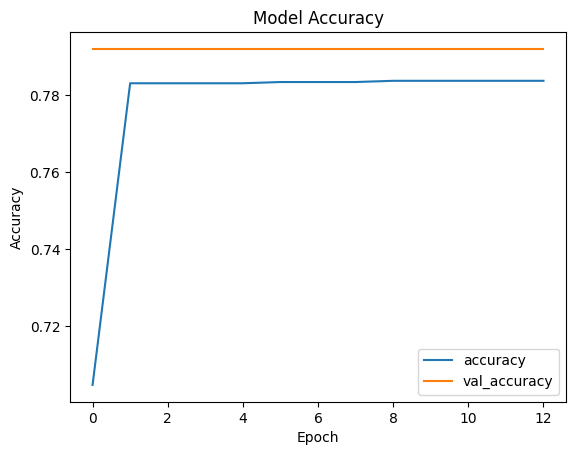

In [22]:
y_pred_train = np.argmax(model.predict(X_train), axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

print("Training Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
13/13 [==============================] - 167s 12s/step - loss: 1.7337 - accuracy: 0.4621 - val_loss: 1.4998 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - 172s 13s/step - loss: 1.5379 - accuracy: 0.6272 - val_loss: 1.3722 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - 159s 12s/step - loss: 1.3371 - accuracy: 0.6633 - val_loss: 1.2260 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - 151s 11s/step - loss: 1.0848 - accuracy: 0.7226 - val_loss: 1.0983 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 5/20
13/13 [==============================] - 159s 12s/step - loss: 0.9037 - accuracy: 0.7704 - val_loss: 0.9860 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 6/20
13/13 [==============================] - 156s 12s/step - loss: 0.8483 - accuracy: 0.7

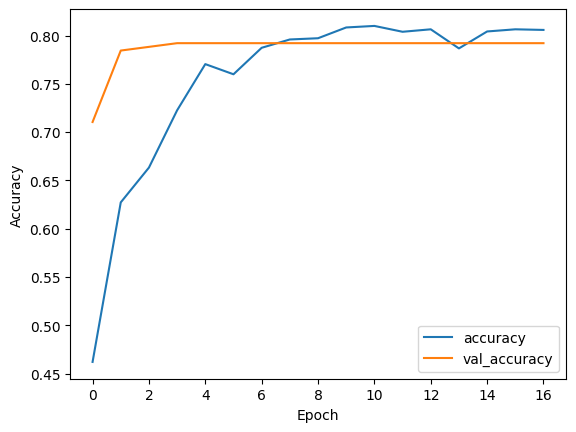

In [24]:
model = Sequential()
model.add(LSTM(units=256, input_shape=(None, 2), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2, callbacks=[EarlyStopping(patience=3), TensorBoard(), reduce_lr])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
y_pred_train = np.argmax(model.predict(X_train), axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

print("Training Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

31/31 [==============================] - 25s 812ms/step
Training Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       384
           2       0.78      1.00      0.88      3077
           3       0.00      0.00      0.00       459

    accuracy                           0.78      3920
   macro avg       0.26      0.33      0.29      3920
weighted avg       0.62      0.78      0.69      3920

Test Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           2       0.76      1.00      0.86       745
           3       0.00      0.00      0.00       121

    accuracy                           0.76       980
   macro avg       0.25      0.33      0.29       980
weighted avg       0.58      0.76      0.66       980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif